In [26]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import re
from fnmatch import filter
import util

In [28]:
#Set Obspack Dirctory 
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
surface_files = [
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
]

obspack_files = {}
for f in surface_files:
    stn = os.path.basename(f).split('_')[1]
    obspack_files[stn] = os.path.basename(f)

In [29]:
#List Models
#model_list = ['TM3', 'miroc', 'cam', 'nies', 'TM5', 'TM5_grid']
model_list = ['TM3', 'miroc', 'TM5']

In [30]:
#List SNO Variables
sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
]

In [31]:
#List Stations
stn_list = ['alt', 'brw', 'cba', 'cgo', 'kum', 'ljo', 'mlo', 'psa', 'smo', 'spo', 'hip', 'orc', 'tom', 'gould']

# Select specific station
stn = stn_list[2] # e.g. for CBA only


In [32]:
#Ingest function for TM3:
#data_path = f"/glade/work/mclong/sno-analysis/simulation-data/TM3-Jena"

def ingest_tm3_data(data_path, stn, sno_vars):
    jena_dict = { 
        'alt' : 'FrALTso.co2.ts',
        'brw' : 'FbBRWso.co2.ts',
        'cba' : 'FrCBAso.co2.ts',
        'cgo' : 'FrCGOso.co2.ts',
        'kum' : 'FrKUMso.co2.ts',
        'ljo' : 'FsLJOso.co2.ts',
        'mlo' : 'FbMLOco.co2.ts',
        'psa' : 'FrPSAso.co2.ts',
        'smo' : 'FrSMOso.co2.ts',
        'spo' : 'FbSPOso.co2.ts',
        'hip' : 'HaHIPxo.co2.ts',
        'orc' : 'HaORCMERGE10xo.co2.ts',
        'tom' : 'HaTOMco.co2.ts',
        'gould' : 'HoGOULDco.co2.ts'
        }
    
    #List Tracers
    tracer_list = [
    'apojena', 'co2cesm', 'co2gridfed', 'co2oco2mip', 'co2somffn', 
    'n2cesm', 'n2era', 'o2cesm', 'o2gk01r16', 'o2gridfed'
    ]
#    TM3 = []
    
#    for stn in stn_list:
    dtracer = f"PRI_{tracer_list[0]}_output1.vGV7.sGV7"
    path = f"{data_path}/{dtracer}/{jena_dict[stn]}"
    df = pd.read_csv(path, delim_whitespace=True, header=None) # , na_values=-599.0000)
    df.columns = ['year.frac', 'year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon', 'hgt', 'obs', 'sigma', tracer_list[0]] 
    for t in tracer_list[1:]:
        dtracer = f"PRI_{t}_output1.vGV7.sGV7"
        path = f"{data_path}/{dtracer}/{jena_dict[stn]}"

        tmp = pd.read_csv(path, delim_whitespace=True, header=0) # , na_values=-599.0000)
        tmp.columns = ['year.frac', 'year', 'month', 'day', 'hour', 'minute', 'second', 'lat', 'lon', 'hgt', 'obs', 'sigma', t] 

        df[t] = tmp[t]
    df = df.rename({'apojena': 'apo_jena', 'co2cesm': 'co2_cesm', 'co2gridfed': 'co2_gridfed', 'co2oco2mip': 'co2_oco2mip', 'co2somffn': 'co2_somffn', 
    'n2cesm': 'n2_cesm', 'n2era': 'n2_era', 'o2cesm': 'o2_cesm', 'o2gk01r16': 'o2_gk01r16', 'o2gridfed': 'o2_gridfed'}, axis=1)

    # merge into original ObsPack, to allow outputting for other uses
    obs_path = f"{obspack_dir}/{obspack_files[stn]}"
    ds = xr.open_dataset(obs_path)
    assert df.shape[0] == ds.dims['obs']

    for v in sno_vars:
        # Add model data into obspact and subtract off background value
        """ 
        For technical reasons (because the runs have formally been done as CO2
        runs to be able to use the CO2 obspack input), an initial condition of

            347.0120 ppm

        has been added to the output files (but the actual transport runs have
        been done from a zero atmosphere).
        """
        ds[v] = df[v] - 347.0120

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})
    ds['dim_0'] = ds['time']
    ds = ds.drop('time').rename({'dim_0': 'time'})


#    TM3.append(ds)

    return ds


In [157]:
data_path = f"/glade/work/mclong/sno-analysis/simulation-data/TM3-Jena"

TM3 = ingest_tm3_data(data_path,stn, sno_vars)
TM3

<xarray.Dataset>
Dimensions:                     (time: 553, calendar_components: 6, dim_concerns: 6, mip_nmodels: 17)
Coordinates:
  * time                        (time) datetime64[ns] 1995-08-16T20:30:00 ......
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels
Data variables: (12/39)
    start_time                  (time) datetime64[ns] ...
    midpoint_time               (time) datetime64[ns] ...
    datetime                    (time) |S100 ...
    time_decimal                (time) float64 ...
    time_components             (time, calendar_components) float64 ...
    solartime_components        (time, calendar_components) float64 ...
    ...                          ...
    co2_cesm                    (time) float64 -11.46 -11.14 ... -43.95 nan
    co2_somffn                  (time) float64 -7.356 -7.222 ... -28.47 nan
    co2_gridfed                 (time) float64 30.16 30.03 30.39 ... 131.1 nan
    co2_oco2mip                 (time) float64 -0.01857 -0.01859 ... 89.27 nan
    n2_cesm                     (time) float64 1.665 0.5485 -2.3 ... -23.02 nan
    n2_era                      (time) float64 13.21 11.94 9.474 ... 8.367 nan
Attributes: (12/129)
    site_code:                                    CBA
    site_name:                                    Cold Bay, Alaska
    site_country:                                 United States
    site_country_flag:                            UNST0001.GIF
    site_latitude:                                55.21
    site_longitude:                               -162.72
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [33]:
#Ingest function for TM5:
#data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/TM5-NOAA"
#good station times: 3,5,7,8,9

def ingest_tm5_data(data_path, stn, sno_vars):
#    TM5 = []
#    for stn in stn_list: 
    path = f"{data_path}/{obspack_files[stn]}"
    ds = xr.open_dataset(path)

    # Andy's time_components are all zeros, have to get from ObsPack 
    ## not working for all stations as some differ by 1 row, need to merge on obspack_id
    obs_path = f"{obspack_dir}/{obspack_files[stn]}"
    tc = xr.open_dataset(obs_path)['time_components']
    tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
    tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
    ds['time'] = pd.to_datetime(tc)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})

    # subtract off background value
    for v in sno_vars:
        ds[v]=ds[v]-400.0

#        TM5.append(ds)
        
    return ds
    

In [ ]:
data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/TM5-NOAA"

TM5 = ingest_tm5_data(data_path, stn, sno_vars)
TM5

<xarray.Dataset>
Dimensions:               (time: 553, calendar_components: 6)
Coordinates:
  * time                  (time) datetime64[ns] 1995-08-16T20:30:00 ... 2020-...
Dimensions without coordinates: calendar_components
Data variables: (12/27)
    time_decimal          (time) float32 ...
    time_components       (time, calendar_components) float64 ...
    solartime_components  (time, calendar_components) float64 ...
    value                 (time) float32 ...
    latitude              (time) float32 ...
    longitude             (time) float32 ...
    ...                    ...
    u                     (time) float32 ...
    v                     (time) float32 ...
    blh                   (time) float32 ...
    q                     (time) float32 ...
    temperature           (time) float32 ...
    pressure              (time) float32 ...
Attributes: (12/137)
    carbontracker_notes:                          This file contains observed...
    site_code:                                    CBA
    site_name:                                    Cold Bay, Alaska
    site_country:                                 United States
    site_country_flag:                            UNST0001.GIF
    site_latitude:                                55.21
    ...                                           ...
    carbontracker_email:                          carbontracker.team@noaa.gov
    carbontracker_url:                            http://carbontracker.noaa.gov
    carbontracker_institution:                    NOAA Earth System Research ...
    conventions:                                  CF-1.5
    carbontracker_history:                        Created on Tue Jul 19 2022 ...
    carbontracker_source:                         CarbonTracker release apo

In [96]:
#Ingest function for MIROC:
#data_path = f"/glade/work/stephens/sno-analysis/simulation-data/MIROC4-ACTM_T42/"

def ingest_miroc_data(data_path, stn, sno_vars):
    path = f"{data_path}/{obspack_files[stn].replace('.nc', '.txt')[4:]}"
    df = pd.read_csv(path, delim_whitespace=True, header=1, na_values=-599.0000)
    df = df.rename({'Year': 'year', 'MM': 'month', 'DD': 'day', 'HH': 'hour', 'MI': 'minute'}, axis=1)

    # merge into original ObsPack, to allow outputting for other uses
    obs_path = f"{obspack_dir}/{obspack_files[stn]}"
    ds = xr.open_dataset(obs_path)

    assert df.shape[0] == ds.dims['obs']
    # subtract off background value
    for v in sno_vars:
        ds[v] = df[v] - 400.0

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})
    ds['dim_0'] = ds['time']
    ds = ds.drop('time').rename({'dim_0': 'time'})
    
    return ds

In [105]:
data_path = f"/glade/work/stephens/sno-analysis/simulation-data/MIROC4-ACTM_T42/"

miroc = ingest_miroc_data(data_path, stn, sno_vars)
miroc

<xarray.Dataset>
Dimensions:                     (time: 553, calendar_components: 6, dim_concerns: 6, mip_nmodels: 17)
Coordinates:
  * time                        (time) datetime64[ns] 1995-08-16T20:30:00 ......
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels
Data variables: (12/39)
    start_time                  (time) datetime64[ns] ...
    midpoint_time               (time) datetime64[ns] ...
    datetime                    (time) |S100 ...
    time_decimal                (time) float64 ...
    time_components             (time, calendar_components) float64 ...
    solartime_components        (time, calendar_components) float64 ...
    ...                          ...
    co2_cesm                    (time) float64 -12.07 -12.0 ... -44.47 -44.49
    co2_somffn                  (time) float64 -6.936 -7.45 ... -28.86 -28.92
    co2_gridfed                 (time) float64 30.13 30.7 30.24 ... 132.1 132.3
    co2_oco2mip                 (time) float64 26.16 26.59 26.25 ... 126.1 126.2
    n2_cesm                     (time) float64 3.371 1.49 ... -23.36 -23.78
    n2_era                      (time) float64 15.26 14.03 9.468 ... 8.793 8.372
Attributes: (12/129)
    site_code:                                    CBA
    site_name:                                    Cold Bay, Alaska
    site_country:                                 United States
    site_country_flag:                            UNST0001.GIF
    site_latitude:                                55.21
    site_longitude:                               -162.72
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [106]:
#Ingest function for NICAM:
#data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/NICAM/primary_data"

def ingest_nicam_data(data_path, stn, sno_vars):
    path = f"{data_path}/{obspack_files[stn].replace('co2_','nicam-tm_gl5_')}"
    ds = xr.open_dataset(path)

    # no variable 'time' - recreate from time_components
    tc = ds['time_components']
    tc = tc.to_dataframe(dim_order=['calendar_components','obs']).unstack(level=0)
    tc.columns = ['year', 'month', 'day', 'hour', 'minute', 'second'] 
    ds['time'] = pd.to_datetime(tc)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})
    
    ds.encoding['missing_value'] = -999999

    return ds


In [107]:
data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/NICAM/primary_data"

nicam = ingest_nicam_data(data_path, stn, sno_vars)
nicam

<xarray.Dataset>
Dimensions:          (time: 553, calendar_components: 6)
Coordinates:
  * time             (time) datetime64[ns] 1995-08-16T20:30:00 ... 2020-12-03...
Dimensions without coordinates: calendar_components
Data variables: (12/21)
    time_decimal     (time) float64 ...
    time_components  (time, calendar_components) int32 ...
    latitude         (time) float32 ...
    longitude        (time) float32 ...
    altitude         (time) float32 ...
    obspack_num      (time) int32 ...
    ...               ...
    co2_somffn       (time) float32 ...
    n2_era           (time) float32 ...
    co2_gridfed      (time) float32 ...
    o2_gridfed       (time) float32 ...
    apo_jena         (time) float32 ...
    co2_oco2mip      (time) float32 ...
Attributes:
    title:      simulated values were from NICAM-TM
    contact:    Yosuke Niwa (CGER/NIES & MRI; e-mail: niwa.yosuke@nies.go.jp)
    reference:  Niwa et al., Geosci. Model Dev., 2017 (doi:10.5194/gmd-10-115...

In [149]:
### NOT WORKING YET

#Ingest function for CAM:
#data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/CAMS_LMDZ"

def ingest_cam_data(data_path, stn, sno_vars):
    cams_dict = { 
        'apo_jena' : 'APO_OCN.carboscope.apo99X_v2021',
        'o2_cesm' : 'O2_OCN.cesm_fosi_smyle',
        'o2_gk01r16' : 'O2_OCN.gk2001_R2016.repeat_monclim',
        'o2_gridfed' : 'O2_FF.GCP-GridFED.v2021.3',
        'co2_cesm' : 'CO2_OCN.cesm_fosi_smyle',
        'co2_somffn' : 'CO2_OCN.MPI-SOM-FFN',
        'co2_gridfed' : 'CO2_FF.GCP-GridFED.v2021.3',
        'co2_oco2mip' : 'CO2_FF.OCO2-MIP.v2020.1',  
        'n2_cesm' : 'N2_OCN.cesm_fosi_smyle',
        'n2_era' : 'N2_OCN.era5_shf'
    }
    obs_path = f"{obspack_dir}/{obspack_files[stn]}"    
    ds = xr.open_dataset(obs_path)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})
    ds['obspack_id'] = ds['obspack_id'].str.decode('utf-8')

        #for v in sno_vars:
        #ds[v]=ds[v]-400.0
    
    for tracer in cams_dict:
        path = f"{data_path}/XSF{cams_dict[tracer]}.txt"

        cams_df = pd.read_csv(path, delim_whitespace=True, names = ['obspack_id', tracer], comment = '#')

        cams_df['obspack_id'] = cams_df['obspack_id'].str.split('_', n = 1, expand=True).iloc[:,1]

        ds = ds.merge(cams_df, join = 'left', compat = 'override') 

    return ds


    

In [150]:
data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/CAMS_LMDZ"

cam = ingest_cam_data(data_path, stn, sno_vars)
cam

<xarray.Dataset>
Dimensions:                     (dim_0: 460634, time: 553, calendar_components: 6, dim_concerns: 6, mip_nmodels: 17)
Coordinates:
  * dim_0                       (dim_0) int64 0 1 2 3 ... 460631 460632 460633
  * time                        (time) datetime64[ns] 1995-08-16T20:30:00 ......
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels
Data variables: (12/39)
    start_time                  (time) datetime64[ns] ...
    midpoint_time               (time) datetime64[ns] ...
    datetime                    (time) |S100 ...
    time_decimal                (time) float64 ...
    time_components             (time, calendar_components) float64 ...
    solartime_components        (time, calendar_components) float64 ...
    ...                          ...
    co2_cesm                    (dim_0) float64 395.9 395.7 ... 354.4 354.4
    co2_somffn                  (dim_0) float64 397.6 397.4 ... 370.6 370.6
    co2_gridfed                 (dim_0) float64 413.2 416.1 ... 527.8 527.8
    co2_oco2mip                 (dim_0) float64 400.0 400.0 ... 485.3 485.3
    n2_cesm                     (dim_0) float64 399.3 396.7 ... 376.9 376.9
    n2_era                      (dim_0) float64 404.8 402.7 ... 416.1 416.1
Attributes: (12/129)
    site_code:                                    CBA
    site_name:                                    Cold Bay, Alaska
    site_country:                                 United States
    site_country_flag:                            UNST0001.GIF
    site_latitude:                                55.21
    site_longitude:                               -162.72
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [110]:
# Ingest function for NIES:
#data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/NIES"
def ingest_nies_data(data_path, stn, sno_vars):

    path = f"{data_path}/{obspack_files[stn]}"
    ds = xr.open_dataset(path)
    
    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time

    return ds   


In [111]:
data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/NIES"

nies = ingest_nies_data(data_path, stn, sno_vars)
nies

<xarray.Dataset>
Dimensions:                     (obs: 553, calendar_components: 6, dim_concerns: 6, mip_nmodels: 17)
Coordinates:
  * obs                         (obs) datetime64[ns] 1995-08-16T20:30:00 ... ...
Dimensions without coordinates: calendar_components, dim_concerns, mip_nmodels
Data variables: (12/40)
    time                        (obs) datetime64[ns] ...
    start_time                  (obs) datetime64[ns] ...
    midpoint_time               (obs) datetime64[ns] ...
    datetime                    (obs) |S100 ...
    time_decimal                (obs) float64 ...
    time_components             (obs, calendar_components) float64 ...
    ...                          ...
    co2_somffn                  (obs) float32 ...
    n2_cesm                     (obs) float32 ...
    n2_era                      (obs) float32 ...
    o2_cesm                     (obs) float32 ...
    o2_gk01r16                  (obs) float32 ...
    o2_gridfed                  (obs) float32 ...
Attributes: (12/129)
    site_code:                                    CBA
    site_name:                                    Cold Bay, Alaska
    site_country:                                 United States
    site_country_flag:                            UNST0001.GIF
    site_latitude:                                55.21
    site_longitude:                               -162.72
    ...                                           ...
    obspack_creation_date:                        2021-08-18T13:54:02.056239
    obspack_warning:                              Every effort is made to cre...
    obspack_fair_use:                             This cooperative data produ...
    obspack_usage_policy:                         www.gml.noaa.gov/ccgg/obspa...
    obspack_identifier_link:                      http://doi.org/10.25925/202...
    obspack_citation:                             Kenneth N. Schuldt, John Mu...

In [123]:
# Loop through selected models to ingest data

model_list = ['TM3', 'miroc', 'TM5', 'nies', 'cam', 'nicam']
for mod in model_list:
    if mod == 'TM3':
        data_path = f"/glade/work/mclong/sno-analysis/simulation-data/TM3-Jena"
        TM3 = ingest_tm3_data(data_path,stn, sno_vars)
    elif mod == 'TM5':
        data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/TM5-NOAA"
        TM5 = ingest_tm5_data(data_path, stn, sno_vars)
    elif mod == 'miroc':
        data_path = f"/glade/work/stephens/sno-analysis/simulation-data/MIROC4-ACTM_T42/"
        miroc = ingest_miroc_data(data_path, stn, sno_vars)
    elif mod == 'nies':
        data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/NIES"
        nies = ingest_nies_data(data_path, stn, sno_vars)
    elif mod == 'cam':
        data_path = f"/glade/p/eol/stephens/longcoll/apo-simulation-data/CAMS_LMDZ"
        cam = ingest_cam_data(data_path, stn, sno_vars)
    elif mod == 'nicam':
        data_path =  f"/glade/p/eol/stephens/longcoll/apo-simulation-data/NICAM/primary_data"
        nicam = ingest_nicam_data(data_path, stn, sno_vars)
    else:
        continue


In [125]:
# Compute Derived APO Variables

def compute_derived_apo(df):
    df['apo_cesm'] = util.compute_apo (
        o2=df['o2_cesm'],
        co2=df['co2_cesm'],
        n2=df['n2_cesm']
    )

    df['apo_diss'] = util.compute_apo (
        o2=df['o2_gk01r16'],
        co2=df['co2_somffn'],
        n2=df['n2_era']
    )

    df['apo_gridfed'] = util.compute_apo (
        o2=df['o2_gridfed'],
        co2=df['co2_gridfed'],
        n2=0.0
    )
    return df

In [151]:
# Compute Derived APO Variables for all models
mod_list = [TM3, miroc, TM5, nies, cam, nicam]

for mod in mod_list:
    mod = compute_derived_apo(mod)


In [171]:
# Create dictionary of model tracer data with time coordinates for plotting 

mod_list = [TM3, miroc, TM5, nies, cam, nicam]
model_list = ['TM3', 'miroc', 'TM5', 'nies', 'cam', 'nicam']

data_dict = {}
i = -1
for mod in mod_list:
    i = i + 1
    data_dict[model_list[i] + '_time'] = mod['time']
    for v in sno_vars: 
        data_dict[model_list[i] + '_' + v] = mod[v]



In [152]:
#Plot SNO Variables
def plot_sno_vars(dsets, sno_vars):

    n_plots = len(sno_vars)
    ncol = int(np.sqrt(n_plots))
    nrow = int(((n_plots / ncol) + n_plots % ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

    for n, v in enumerate(sno_vars):
        ip, jp = np.unravel_index(n, axs.shape)

        ax = axs[ip, jp]
        i = -1
        for ds in dsets:
            i = i +1
            ds[v].plot(ax=ax, label = str(dsets[i]))
        ax.set_title(v)

    plt.tight_layout();    

    for n in range(n+1, nrow*ncol):
        ip, jp = np.unravel_index(n, (nrow, ncol))
        axs[ip, jp].remove()


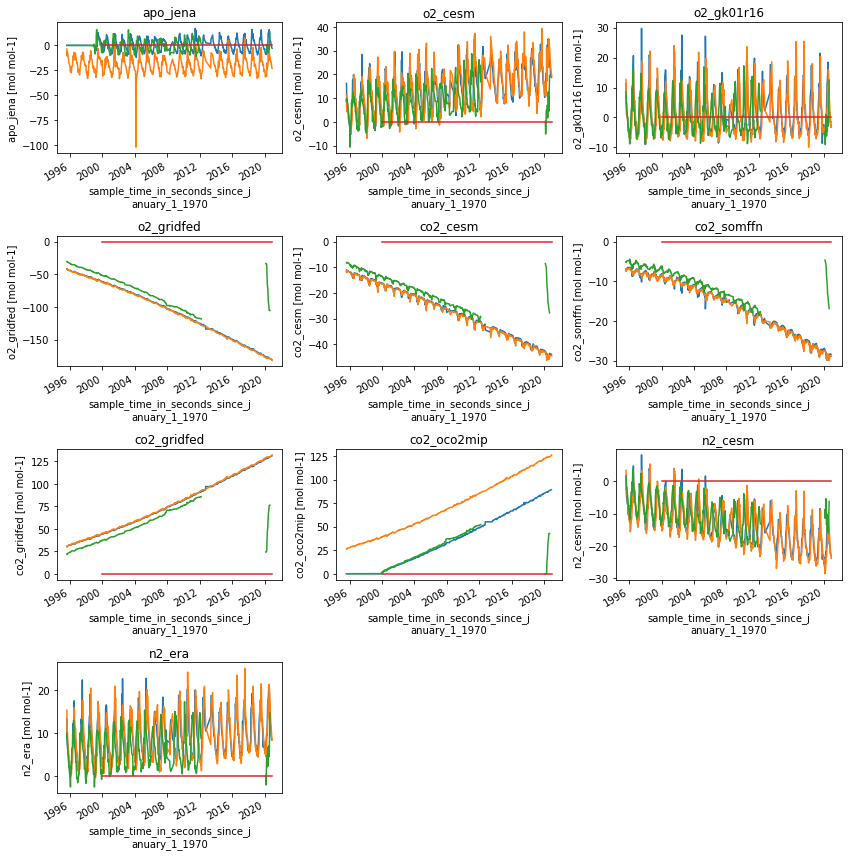

In [153]:
plot_sno_vars(mod_list[0:4], sno_vars)